Choix du dataset : J’ai choisi ce dataset ENAPE car il porte sur l’abandon scolaire, un sujet important qui me touche personnellement.

Prétraitement : J’ai d’abord analysé les données, repéré les valeurs manquantes et choisi de les imputer par la médiane, car ce jeu de données contient 
plusieurs variables numériques avec des valeurs manquantes.

Nettoyage : Les valeurs aberrantes ont été détectées via les boxplots puis supprimées avec la méthode IQR, ce qui améliore la robustesse du modèle.

Visualisations : Les visualisations m’ont aidé à comprendre la distribution des variables et leurs corrélations avec la cible, ce qui guide la sélection
des features et le choix du modèle.

Modélisation : J’ai opté pour une forêt aléatoire (Random Forest) car c’est un modèle robuste, adapté aux données hétérogènes et peu sensible aux valeurs
manquantes ou redondances.

Évaluation : Le rapport de classification et la matrice de confusion me permettent d’évaluer la qualité des prédictions, notamment la précision,
le rappel et la F1-score.

In [ ]:
# importation des données

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
# chargement du dataset 

In [5]:
df = pd.read_csv("df03_Dataset_ENAPE.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32343 entries, 0 to 32342
Data columns (total 67 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FOLIO            32343 non-null  int64  
 1   SEXO             32343 non-null  int64  
 2   EDAD             32343 non-null  int64  
 3   edu_inicial      32343 non-null  float64
 4   inscrito         32343 non-null  float64
 5   nivel_edu        32343 non-null  float64
 6   terminado        32343 non-null  float64
 7   nt_causa         32343 non-null  float64
 8   asesorias        32343 non-null  float64
 9   extraord         32343 non-null  float64
 10  recursado        32343 non-null  float64
 11  ev_tareas        32343 non-null  float64
 12  ev_exam          32343 non-null  float64
 13  ev_digital       32343 non-null  float64
 14  ev_partcp        32343 non-null  float64
 15  ev_libreta       32343 non-null  float64
 16  ev_asist         32343 non-null  float64
 17  ev_otro     

In [7]:
df.head()

,FOLIO,SEXO,EDAD,edu_inicial,inscrito,nivel_edu,terminado,nt_causa,asesorias,extraord,...,tv_plana,tablet,smartphone,InternetF,sIF_causa,mejora_vida,mejora_trabajo,mejor_decisor,ENT,FACTOR_y
0,2,1,13,0.0,1.0,3.0,1.0,0.0,2.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,24,809
1,2,2,19,0.0,1.0,9.0,1.0,0.0,1.0,2.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,24,809
2,7,2,8,0.0,1.0,3.0,1.0,0.0,2.0,0.0,...,1.0,2.0,1.0,1.0,0.0,2.0,2.0,3.0,22,722
3,7,1,26,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,0.0,2.0,2.0,3.0,22,722
4,9,1,27,0.0,1.0,9.0,1.0,0.0,2.0,2.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,26,425


In [8]:
df.isnull().sum()

FOLIO             0
SEXO              0
EDAD              0
edu_inicial       0
inscrito          0
                 ..
mejora_vida       0
mejora_trabajo    0
mejor_decisor     0
ENT               0
FACTOR_y          0
Length: 67, dtype: int64

In [ ]:
# Filtre de de la varaible cible 

In [9]:
# Filtrer la cible terminée valide (0 ou 1)
df = df[df['terminado'].isin([0, 1])]

In [ ]:
# Selection des colonnes qui seront utilisés dans le cadre de notre et notre cible 

In [10]:
features = [
    'SEXO', 'EDAD', 'max_nivel_esp',
    'smartphone', 'tablet', 'pc', 'laptop', 'InternetF',
    't_mama', 't_papa', 't_fam_mujer', 't_fam_hombre',
    'estres', 'depresion', 'desespero', 'antisocial',
    'med_plataform', 'med_clases_v', 'med_presencial',
    'm_impresos', 'm_audio_vid', 'm_expos'
]
target = 'terminado'

In [ ]:
#  Visualisation initiale (distributions et corrélations)

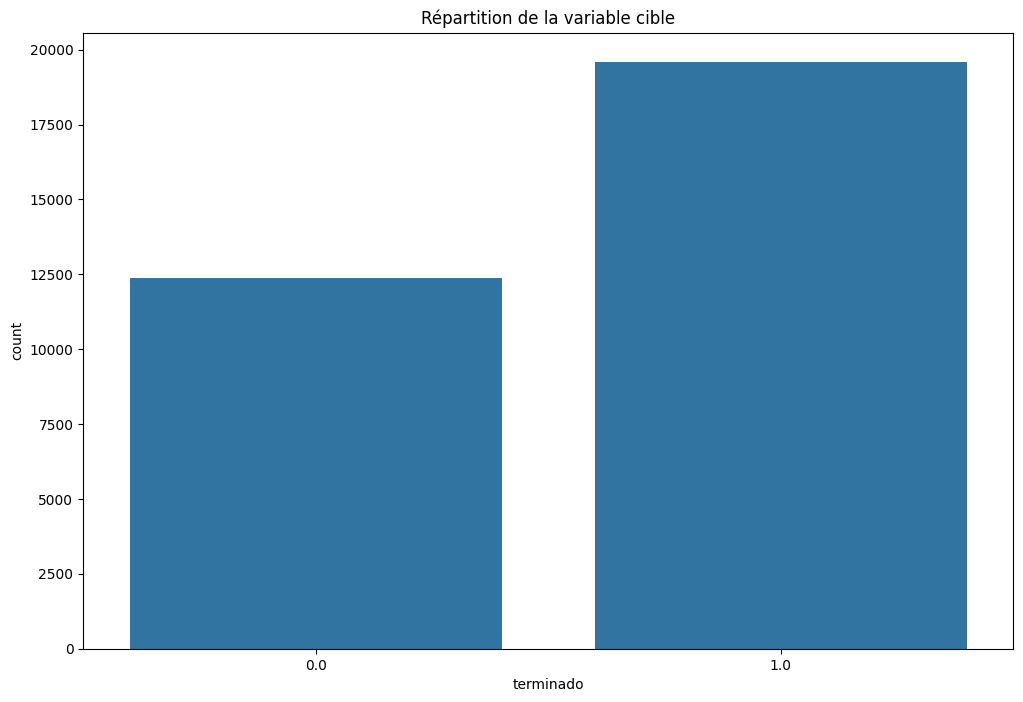

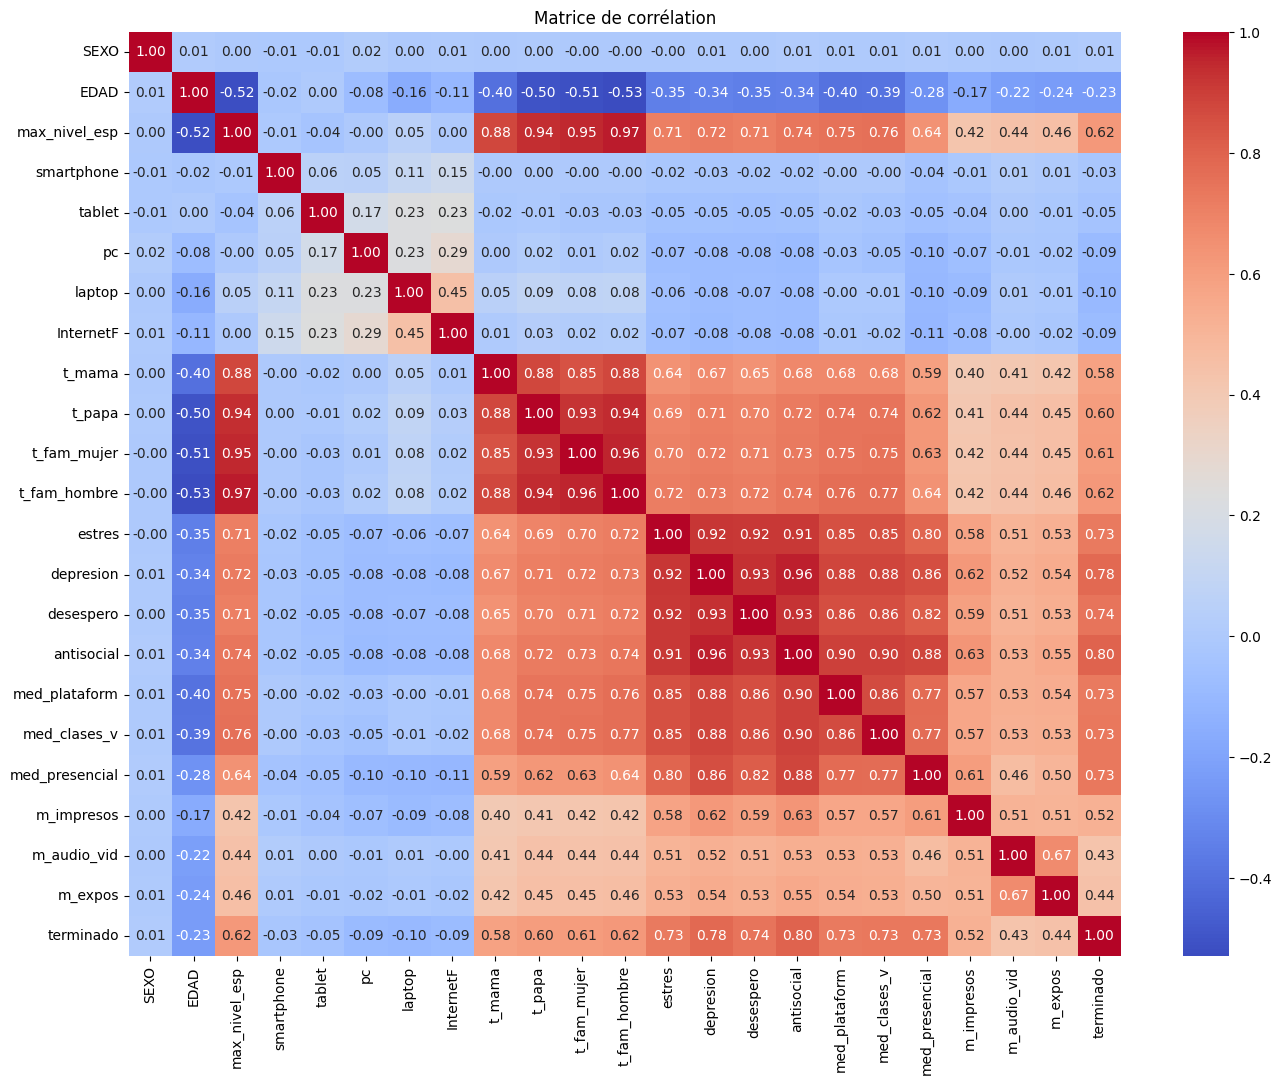

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(x=target, data=df)
plt.title("Répartition de la variable cible")
plt.show()

plt.figure(figsize=(16, 12))
sns.heatmap(df[features + [target]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

In [ ]:
# Visualiser les boxplots pour détecter valeurs aberrantes

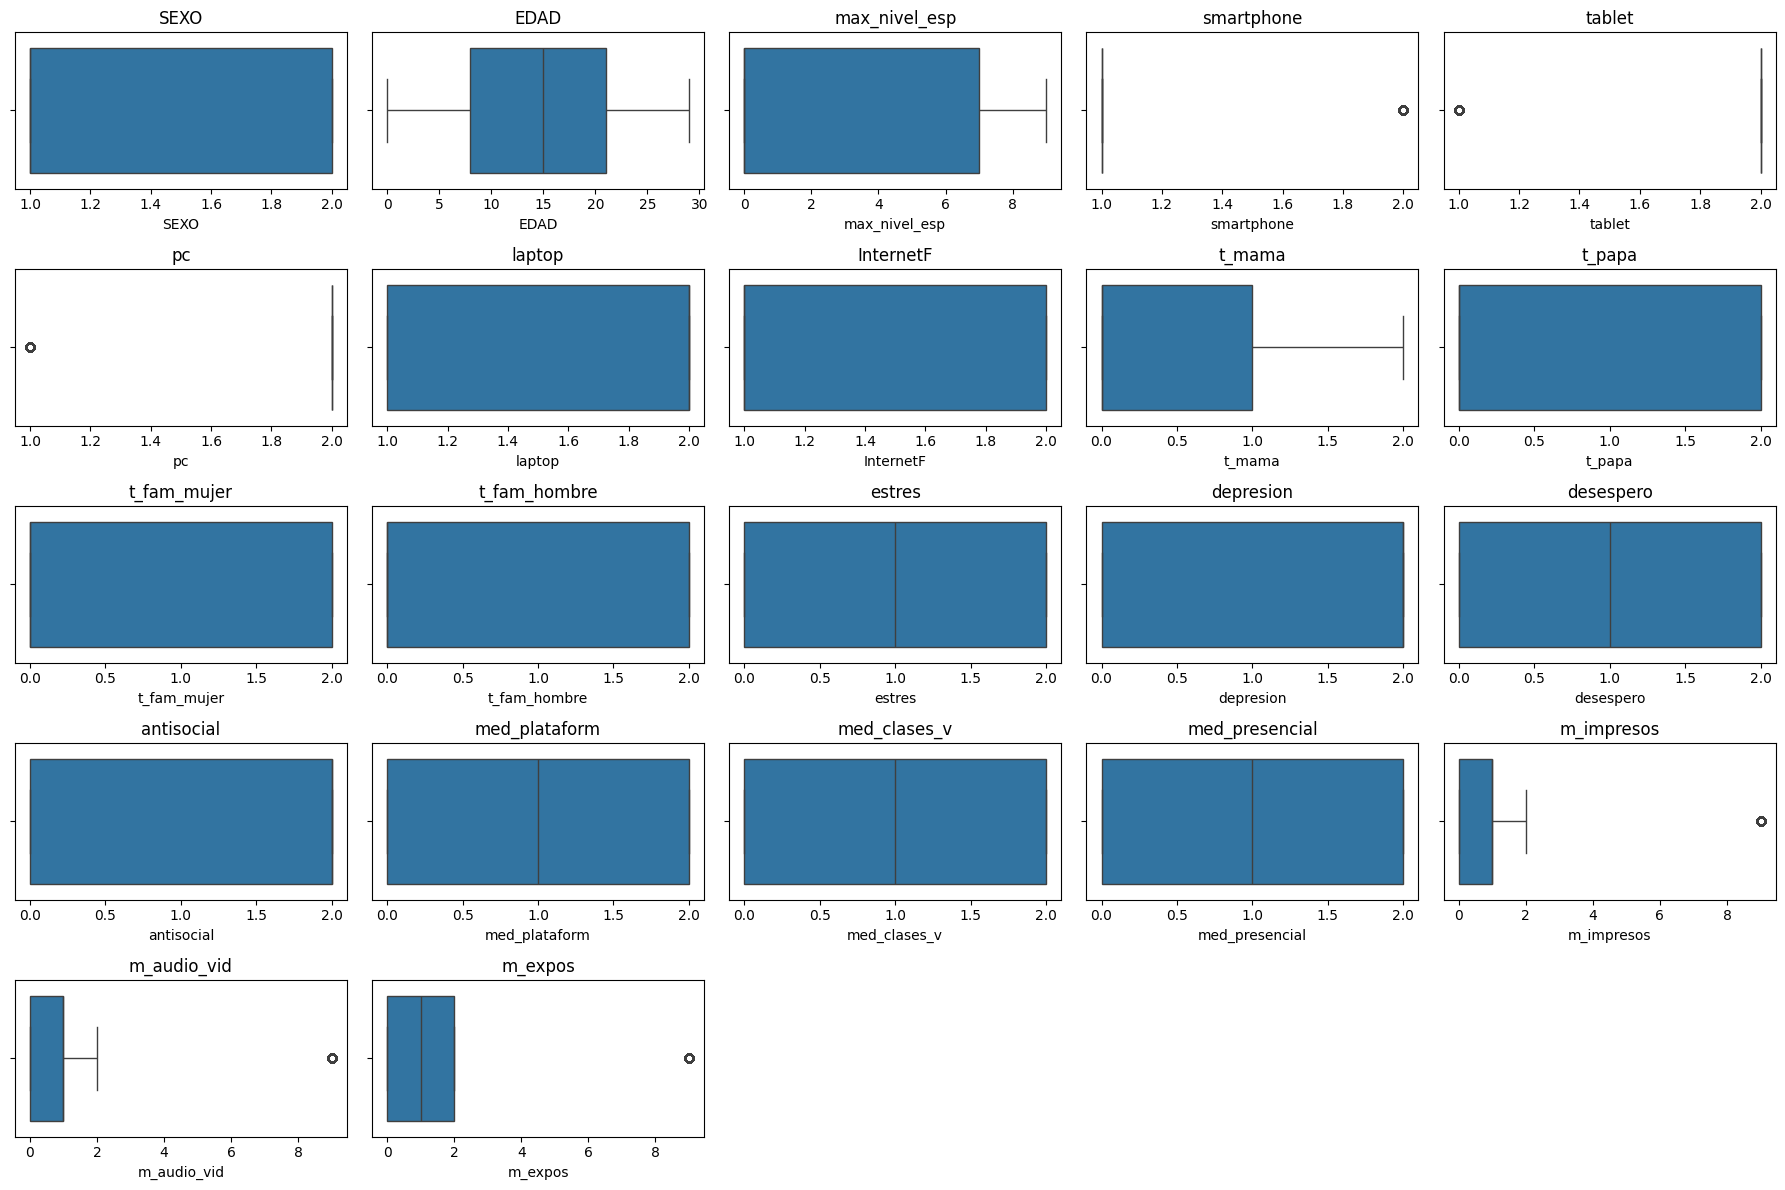

In [12]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(features):
    plt.subplot(5, 5, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
# Gestion des valeurs aberrantes (IQR)

In [13]:
def remove_outliers_iqr(df, features):
    df_clean = df.copy()
    for col in features:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = df_clean.shape[0]
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
        after = df_clean.shape[0]
        print(f"{col} : supprimé {before - after} valeurs aberrantes")
    return df_clean

df_clean = remove_outliers_iqr(df, features)
print(f"Taille après nettoyage des outliers : {df_clean.shape[0]}")

SEXO : supprimé 0 valeurs aberrantes
EDAD : supprimé 0 valeurs aberrantes
max_nivel_esp : supprimé 0 valeurs aberrantes
smartphone : supprimé 1398 valeurs aberrantes
tablet : supprimé 7035 valeurs aberrantes
pc : supprimé 4350 valeurs aberrantes
laptop : supprimé 0 valeurs aberrantes
InternetF : supprimé 0 valeurs aberrantes
t_mama : supprimé 0 valeurs aberrantes
t_papa : supprimé 0 valeurs aberrantes
t_fam_mujer : supprimé 0 valeurs aberrantes
t_fam_hombre : supprimé 0 valeurs aberrantes
estres : supprimé 0 valeurs aberrantes
depresion : supprimé 0 valeurs aberrantes
desespero : supprimé 0 valeurs aberrantes
antisocial : supprimé 0 valeurs aberrantes
med_plataform : supprimé 0 valeurs aberrantes
med_clases_v : supprimé 0 valeurs aberrantes
med_presencial : supprimé 0 valeurs aberrantes
m_impresos : supprimé 108 valeurs aberrantes
m_audio_vid : supprimé 402 valeurs aberrantes
m_expos : supprimé 239 valeurs aberrantes
Taille après nettoyage des outliers : 18423


In [ ]:
# Visualisation après nettoyage

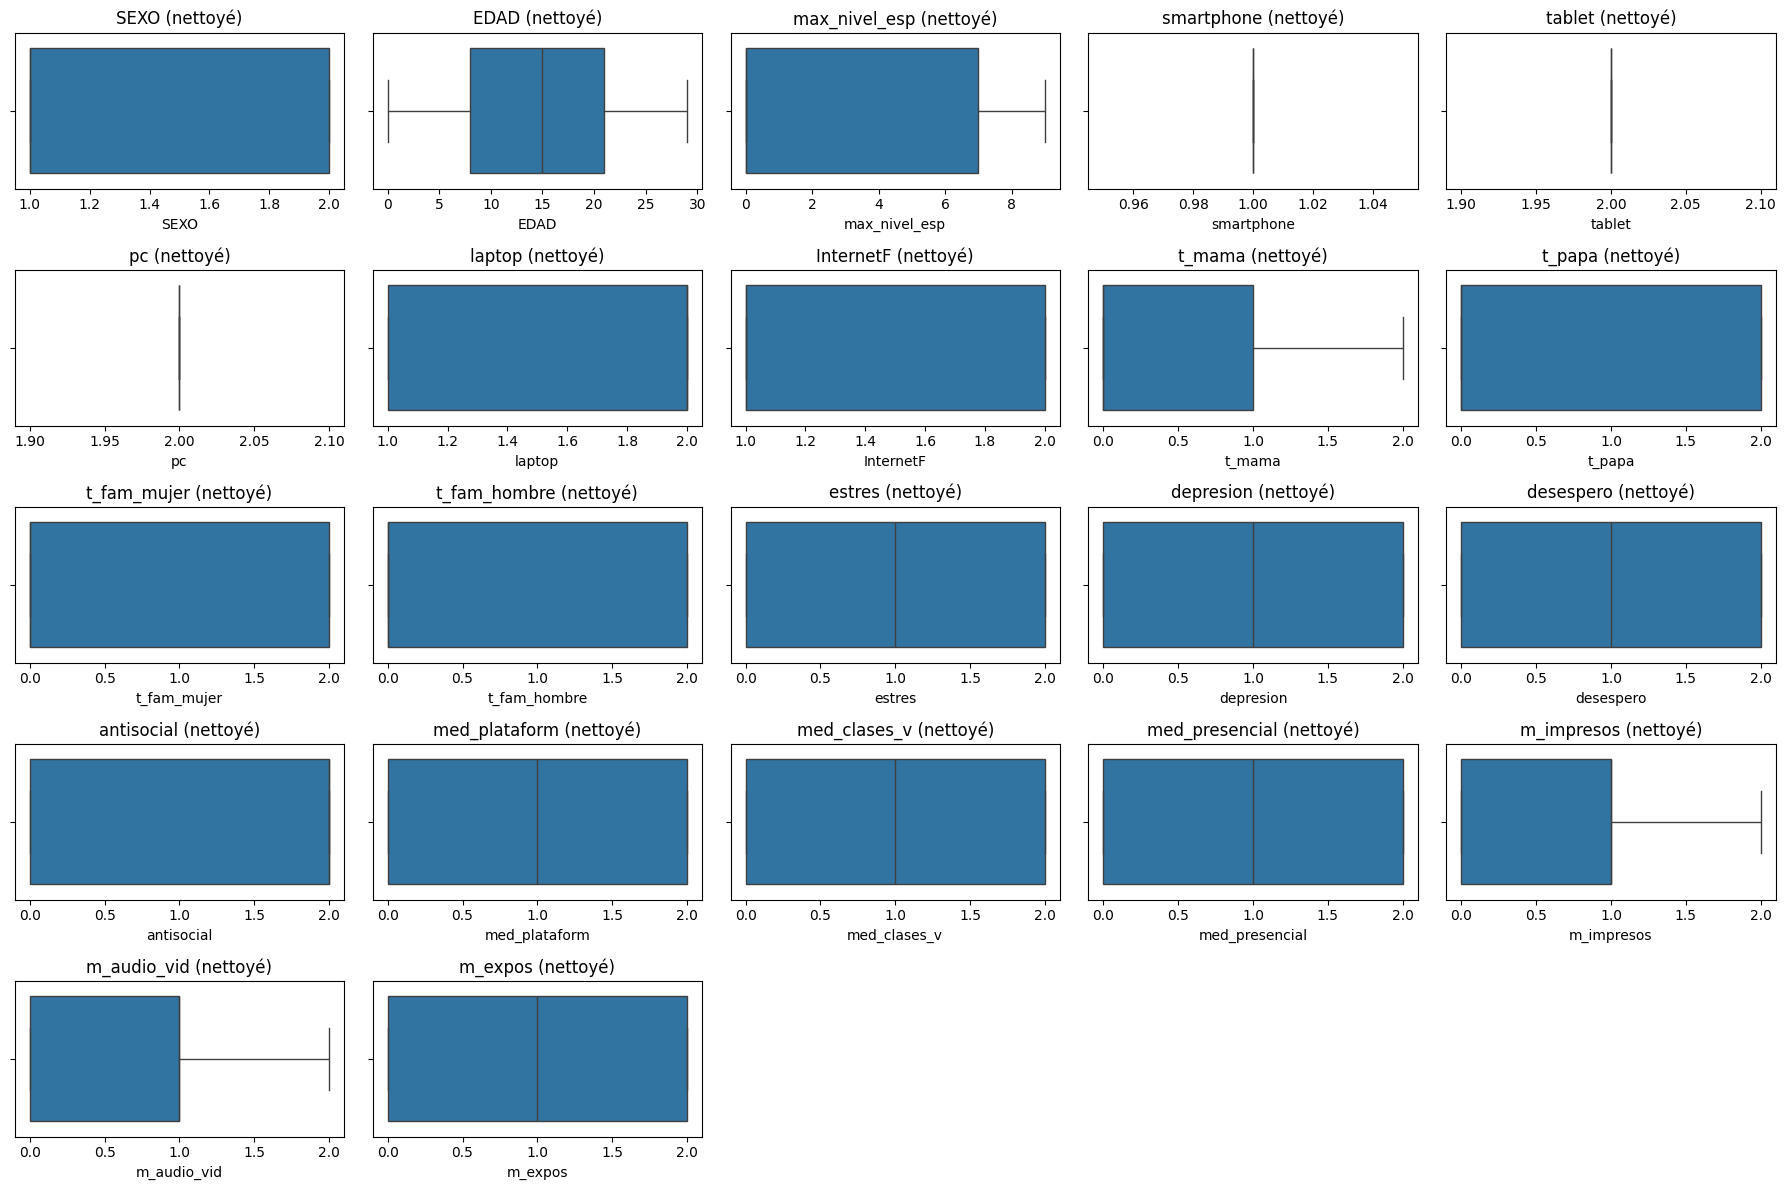

In [14]:

plt.figure(figsize=(18, 12))
for i, col in enumerate(features):
    plt.subplot(5, 5, i+1)
    sns.boxplot(x=df_clean[col])
    plt.title(f"{col} (nettoyé)")
plt.tight_layout()
plt.show()

In [ ]:
# Préparation données pour modélisation

In [15]:

X = df_clean[features]
y = df_clean[target]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Séparation train/test

In [16]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Choix et entraînement du modèle

In [17]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Évaluation du modèle

In [18]:

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      1581
         1.0       0.94      0.92      0.93      2104

    accuracy                           0.92      3685
   macro avg       0.91      0.92      0.92      3685
weighted avg       0.92      0.92      0.92      3685

Confusion Matrix:
 [[1449  132]
 [ 173 1931]]
